In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly
import plotly.graph_objects as go

from state_codes import state_lat_long, us_state_abbrev

D:\Anaconda\envs\pytorch\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
D:\Anaconda\envs\pytorch\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [3]:
def extract_lat(input_state):
    return state_lat_long[input_state][0]

def extract_long(input_state):
    return state_lat_long[input_state][1]

In [47]:
# total cases by state (and add long/lat)
totals_url = r"https://api.covidtracking.com/v1/states/daily.csv"
totals_df = pd.read_csv(totals_url)

totals_df = totals_df[totals_df['date']==20200930][['state','positive','totalTestResults']]
state_filter = totals_df["state"].isin(us_state_abbrev.values())
totals_df = totals_df[state_filter]
totals_df['lat'] = totals_df['state'].apply(extract_lat)
totals_df['long'] = totals_df['state'].apply(extract_long)
totals_df.head()

,state,positive,totalTestResults,lat,long
8848,AK,7889.0,457207.0,66.160507,-153.369141
8849,AL,154701.0,1132039.0,32.318230,-86.902298
8850,AR,83697.0,1029717.0,34.799999,-92.199997
8852,AZ,218507.0,2193467.0,34.048927,-111.093735
8853,CA,810625.0,14705202.0,36.778259,-119.417931


In [48]:
x = np.array(totals_df['positive'])
population = np.array(totals_df['totalTestResults'])

In [76]:
# implementation of Laplace mechanism
def add_laplace_noise(x,epsilon,delta_f=1):
    return x+np.random.laplace(0,delta_f/epsilon,x.shape)

In [77]:
epsilons = [1e-3, 1e-2, 1e-1, 1, 10, 100]

In [101]:
N = len(x)
dists = []
for epsilon in epsilons:
    dist = 1/N * np.abs(add_laplace_noise(x,epsilon,1)-x) @ (1/population)
    dists.append(dist)

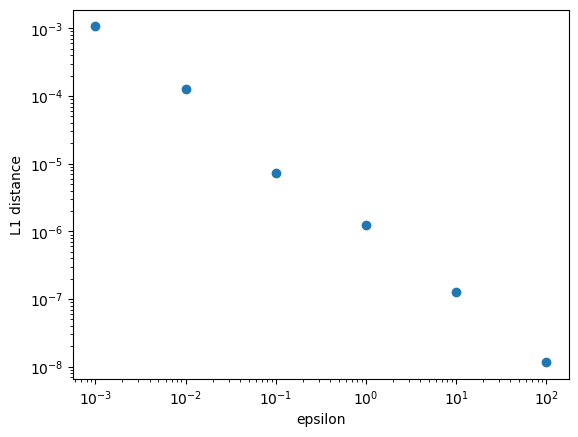

In [107]:
plt.scatter(x=[1e-3, 1e-2, 1e-1, 1, 10, 100],y=dists)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('epsilon')
plt.ylabel('L1 distance')
plt.show()

In [82]:
y = add_laplace_noise(x,0.5,1)

In [83]:
noised_df = totals_df.copy()
noised_df['positive'] = y

In [84]:
noised_df.head()

,state,positive,totalTestResults,lat,long,label
8848,AK,7889.797920,457207.0,66.160507,-153.369141,AK<br>7889.0
8849,AL,154699.724788,1132039.0,32.318230,-86.902298,AL<br>154701.0
8850,AR,83695.118054,1029717.0,34.799999,-92.199997,AR<br>83697.0
8852,AZ,218506.878801,2193467.0,34.048927,-111.093735,AZ<br>218507.0
8853,CA,810621.117487,14705202.0,36.778259,-119.417931,CA<br>810625.0


In [85]:
#Add column for labels
covid_w_labels = totals_df
covid_w_labels['label'] = totals_df['state'] + '<br>' + totals_df['positive'].astype(str)
covid_w_labels.head(5)

# Set size bounds
size_vals = noised_df['positive']
max_marker_size = 75
min_marker_size = 3
sizeref_scale = 2. * max(size_vals) / (max_marker_size ** 2)

noised_w_labels = noised_df
noised_w_labels['label'] = noised_df['state'] + '<br>' + noised_df['positive'].astype(str)
noised_w_labels.head(5)

# Set size bounds
noised_vals = totals_df['positive']
max_marker_size = 75
min_marker_size = 3
noised_sizeref_scale = 2. * max(noised_vals) / (max_marker_size ** 2)

# Plot, plotly, plot!
data1 = go.Scattergeo(
        lon = totals_df['long'],
        lat = totals_df['lat'],
        mode='markers',
        text = noised_w_labels['label'],
        marker=dict(
            size=size_vals,
            sizemode='area',
            sizeref=sizeref_scale,
            sizemin=min_marker_size,
            color = 'Red',
        ))
data2 = go.Scattergeo(
        lon = totals_df['long'],
        lat = totals_df['lat'],
        mode='markers',
        text = noised_w_labels['label'],
        marker=dict(
            size=noised_vals,
            sizemode='area',
            sizeref=noised_sizeref_scale,
            sizemin=min_marker_size,
            color = 'Blue',
        ))

fig = go.Figure(data=data1)
     
fig.update_layout(
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=0
    ),
    geo_scope='usa', # limit map scope to USA
)


In [86]:
fig = go.Figure(data=data2)
     
fig.update_layout(
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=0
    ),
    geo_scope='usa', # limit map scope to USA
)

In [87]:
from autodp.mechanism_zoo import LaplaceMechanism

In [93]:
mech = LaplaceMechanism(b=1/0.5)
epss = []
for delta in [0.5, 0.4, 0.3, 0.2, 0.1, 1e-8]:
    eps = mech.get_approxDP(delta)
    epss.append(eps)

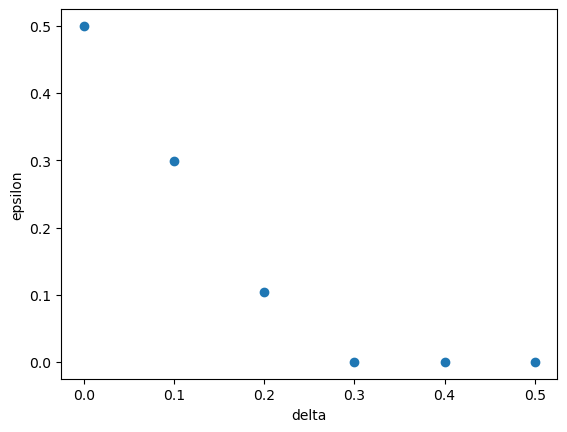

In [98]:
plt.scatter(x=[0.5, 0.4, 0.3, 0.2, 0.1, 1e-8],y=epss)
plt.xlabel('delta')
plt.ylabel('epsilon')
plt.show()